# Big Data Analysis Project - Data Exploratory Analysis

### This is a course project for Concordia's Bigdata class (SOEN691 UU) by Dr. Tristan Glatard in Winter 2020.
*Team Members:*
- Le, Manh Quoc Dat (Student ID: 40153127)<br />
- Tran, Trong Tuan (Student ID: 40151694)<br />
- Phan, Vu Hong Hai (Student ID: 40154023)<br />
- Zhang, Yefei (Student ID: 40153319)<br />

Main project repository: https://github.com/HongHaiPV/concordia-bigdata-project <br />
Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home <br />
>Jianmo Ni, Larry Muhlstein, and Julian McAuley. 2019. Modeling Heart Rate and Activity Data for Personalized Fitness Recommendation. In Proceedings of the 2019 World Wide Web Conference (WWW’19), May 13–17, 2019, San
Francisco, CA, USA. ACM, New York, NY, USA, 11 pages. https://doi.org/10.1145/3308558.3313643
<br />

*The purpose of exploratory analysis is to have an insight of the data set and some initial visual inference, as well as looking for missing data & data imbalance.*

### Preparation - Project framework
We use the same Python version 3.5 as in the course's lab assignments, and the project will also base on PySpark as the main framework to work with the big data set. For the detailed python enviroment and package setup, please follow the guide from the lab: https://github.com/azazel7/BigData-Lab/blob/master/installation_guides/guide.md <br />
We also use Matplotlib as the main package for plotting.

### A. Initialize pyspark framework and load data into pyspark's dataframe
Import necessary modules/ libraries for use later and load the data set into spark dataframe:<br />
   *(Note: the raw data and metadata files are download from the source above, unzipped and put into 'data' folder)*

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats

InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '12G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = './data/endomondoHR.json'
#filename_metadata = './data/endomondoMeta.json'
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")

# Load meta data file into pyspark data frame as well
#df_meta = spark.read.json(filename_metadata, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))


Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


### B. Let's have an overview of the raw data set
#### 1) Schema, columns & datatypes of the data set:
   *The data set has both single value columns (int, string) and columns made of arrays/list.*

In [3]:
print('Data schema:')
df.printSchema()
print('\nColumns & datatypes:')
pd.DataFrame(df.dtypes, columns =['Column Name','Data type'])


Data schema:
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)


Columns & datatypes:


Column Name      Data type
0     altitude  array<double>
1       gender         string
2   heart_rate  array<bigint>
3           id         bigint
4     latitude  array<double>
5    longitude  array<double>
6        speed  array<double>
7        sport         string
8    timestamp  array<bigint>
9          url         string
10      userId         bigint

#### 2) Data set description and display of the first 2 rows:
*Note: The describe function auto exlcuded the columns with list/ array type.<br />Based on the column type, data frame description and the first 2 rows, we know that each data row is a record of a workout of a single user, with the associated activity type (`sport`) and orther data like heart rates, locations and record times (`timestamp`).*

In [4]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print('\nFisrt 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


summary   gender                   id     sport  \
0   count   253020               253020    253020   
1    mean     None  3.566244412926132E8      None   
2  stddev     None  1.574845634895318E8      None   
3     min   female                99296  aerobics   
4     max  unknown            674008008      yoga   

                                                 url              userId  
0                                             253020              253020  
1                                               None   4619648.939783417  
2                                               None  3932877.7296880507  
3  https://www.endomondo.com/users/10014612/worko...                  69  
4  https://www.endomondo.com/users/9991401/workou...            15481421


Fisrt 2 data rows:


altitude gender  \
0  [41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....   male   
1  [38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....   male   

                                          heart_rate         id  \
0  [100, 111, 120, 119, 120, 116, 125, 128, 131, ...  396826535   
1  [100, 105, 111, 110, 108, 115, 126, 130, 132, ...  392337038   

                                            latitude  \
0  [60.173348765820265, 60.173239801079035, 60.17...   
1  [60.173247596248984, 60.17320962622762, 60.172...   

                                           longitude  \
0  [24.64977040886879, 24.65014273300767, 24.6509...   
1  [24.649855233728886, 24.65015547350049, 24.650...   

                                               speed sport  \
0  [6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...  bike   
1  [9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...  bike   

                                           timestamp  \
0  [1408898746, 1408898754, 1408898765, 140889877...   
1  [1408221682, 1408221687, 1408221699, 140822170...   

                                                 url    userId  
0  https://www.endomondo.com/users/10921915/worko...  10921915  
1  https://www.endomondo.com/users/10921915/worko...  10921915

#### 3) Check for missing values and abnormal zeroes
After having a first sight of the columns, the first thing we should check is if the data set having any missing value.
- For string columns, we check for `None` and `null`
- For numeric columns, we check for zeroes and `NaN`
- For array type columns, we check if the array contain zeroes or `NaN`

In [5]:

string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id','userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column: missing_count})
    if column in numeric_columns:
        missing_count = df.where(col(column).isin([0, None, np.nan])).count()
        # | col(column).eqNullSafe(float('NaN'))
        # col(column) == 0 | 
        missing_values.update({column: missing_count})
    if column in  array_columns:
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column: missing_count})
        
print('Records with missing/abnormal values across columns in the data set:')
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df.index = ['Missing/abnormal value records count']
missing_df

Records with missing/abnormal values across columns in the data set:


altitude  gender  heart_rate  id  \
Missing/abnormal value records count     40848       0        1280   0   

                                      latitude  longitude  speed  sport  \
Missing/abnormal value records count       113        113   7741      0   

                                      timestamp  url  userId  
Missing/abnormal value records count          0    0       0

The result showed that there are a lot of workouts with missing data or zeroes. For `altitude`, `longtitude` & `latitude` columns it might be normal (since the altitude is compared to sea level so its values can be positive or negative numbers, also for longtitude & latitude), but for the remaining columns (`speed` and `heart_rate`), the missing data is abnormal. So we will remove zero heart rates and with the large amount of missing speed records, we might follow the original paper to compute the `speed` column by ourselves. [1]

#### 4) High level summary on data set
After the brief overview of what the columns look like, next we will have some insight on users count, activity (sport) type counts and genders, and also total activities (workouts) taken by each gender.<br />
*we will also look further into each datarow and observe how many data points were recorded per activity (workout). The new column `PerWorkoutRecordCount` is determine by the size, or number of elements of the list in `timestamp` column of each row.*<br />
*A notice is that there were some activities without clear info about gender (recorded as `unknown`).*

In [6]:
# Create new column 'PerWorkoutRecordCount' to count the number of timestamps recorded per row/workout
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))

# This part is writen as a function to be used again later
def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())
    sum_temp = df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0],',d')
    columns=['Users count', 'Activity types count','Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
    gender_activities_count = df.groupBy('gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(gender_activities_count.set_index('gender'), on='gender'
                                                        , how='inner', lsuffix='_gu')
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return sum_df, gender_user_activity_count

sum_dfs= user_activity_workout_summarize(df)
print('\nOverall data set summary on users, activities(workouts) and number of fitness records (pre-filtering):')
sum_dfs[0]
print('\nSummarize on genders:')
sum_dfs[1]
print('\nNew PerWorkoutRecordCount column (first 5 rows):')
df.select('userId', 'id', 'sport', 'timestamp', 'PerWorkoutRecordCount').limit(5).toPandas()
print('\nStatistic summary of the PerWorkoutRecordCount column:')
df.select('PerWorkoutRecordCount').toPandas().describe()



Overall data set summary on users, activities(workouts) and number of fitness records (pre-filtering):


Users count Activity types count Workouts count Total records count
0       1,104                   49        253,020         111,541,956


Summarize on genders:


Gender  # of users  Activities (workouts) count
0  unknown          15                         1942
1   female         110                        15959
2     male         979                       235119


New PerWorkoutRecordCount column (first 5 rows):


userId         id             sport  \
0  10921915  396826535              bike   
1  10921915  392337038              bike   
2  10921915  389643739              bike   
3  10921915  386729739              bike   
4  10921915  383186560  bike (transport)   

                                           timestamp  PerWorkoutRecordCount  
0  [1408898746, 1408898754, 1408898765, 140889877...                    500  
1  [1408221682, 1408221687, 1408221699, 140822170...                    500  
2  [1407858459, 1407858466, 1407858478, 140785849...                    500  
3  [1407432042, 1407432048, 1407432056, 140743206...                    500  
4  [1406909434, 1406909436, 1406909437, 140690943...                    500


Statistic summary of the PerWorkoutRecordCount column:


PerWorkoutRecordCount
count          253020.000000
mean              440.842447
std               125.161382
min                 1.000000
25%               495.000000
50%               500.000000
75%               500.000000
max               500.000000

*From the statistic summary of the `PerWorkoutRecordCount` column, we saw that up to 75% of the workouts in the data set contain 495 to 500 data records (timestamps). There are some workouts having as little as only a single record, which would make no meaning to be counted into the data set and be used as training/test data. **So the first filtering we will apply is to filter out any row with less than 50 timestamps recorded.** [2]*

In [7]:
print('Number of workouts that have less than 50 records and statistic summary:')
removed_df = df.select('PerWorkoutRecordCount').where(df.PerWorkoutRecordCount < 50)\
    .toPandas().describe().astype(int)
removed_df.rename(columns = {'PerWorkoutRecordCount':'PerWorkoutRecordCount < 50'}, inplace = True)
removed_df

Number of workouts that have less than 50 records and statistic summary:


PerWorkoutRecordCount < 50
count                        5541
mean                           23
std                            14
min                             1
25%                            11
50%                            22
75%                            36
max                            49

Show the top 5 workout types (sports) that have most people joined:

In [8]:
ranked_sport_users_df = df.select(df.sport, df.userId) \
    .distinct() \
    .groupBy(df.sport) \
    .count() \
    .orderBy("count", ascending=False)
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]

highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()
highest_sport_users_df.rename(columns = {'count':'Users count'}, inplace = True)

sport  Users count  percentage
0               run          865   25.130738
1              bike          794   23.067984
2     mountain bike          336    9.761766
3  bike (transport)          252    7.321325
4              walk          209    6.072051
5            others          986   28.646136

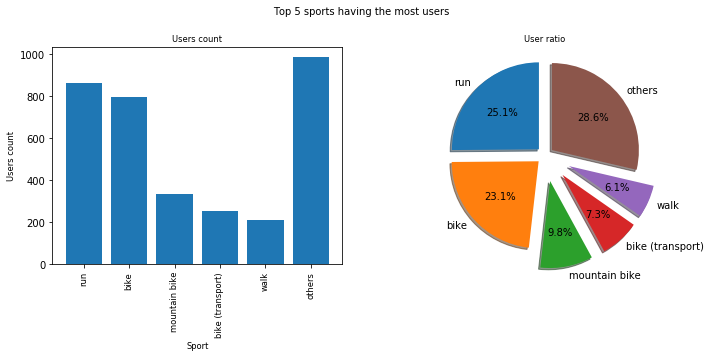

In [9]:
highest_sport_users_df_renamed = highest_sport_users_df
highest_sport_users_df_renamed['percentage'] = highest_sport_users_df['Users count'] / total_sports_users * 100
others = {'sport': 'others', 'Users count': total_sports_users - sum(highest_sport_users_df_renamed['Users count'])
         , 'percentage': 100 - sum(highest_sport_users_df_renamed['percentage'])}
highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(others, ignore_index=True)
highest_sport_users_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_sport_users_df_renamed['sport']
                   , height=highest_sport_users_df_renamed['Users count'])
title0 = axs[0].set_title('Users count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Users count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_sport_users_df_renamed['sport'],rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(x=highest_sport_users_df_renamed['percentage'], labels=highest_sport_users_df_renamed['sport']
                  , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
                    #, pctdistance=1.2, labeldistance=1.4
                  , radius=1)

text = fig.text(0.5, 1.02, 'Top 5 sports having the most users', ha='center', va='top', transform=fig.transFigure)

The data shows that running, walking and biking-related activities are the most spent by users, which is quite reasonable due to those exercises' convenience without much investment.

#### 4) Summarize on gender participation distribution by activities:
  *As shown in the previous high level summary, there are totally 49 kinds of sports (activity types) in this dataset, from the detailed table below, we can see that most of the recorded workouts happened on a few common sports only like run, walk, biking, etc..<br />
  Moreover, in addition to summary tables, we will also have look at a plot from now to have a more visualized feel.*


List of all activities:


sport  count                
gender                          female    male unknown
0                      aerobics      3      43       0
1                     badminton      0      17       0
2                    basketball      0      14       0
3              beach volleyball      0       2       0
4                          bike   4172   92966     863
5              bike (transport)    414   10030       1
6              circuit training     22     196       0
7                      climbing      1       5       0
8       core stability training    143    1103      16
9          cross-country skiing    194     755       0
10                      dancing      0       0       1
11              downhill skiing      2     142       0
12                   elliptical     38      45       0
13              fitness walking    173     228       1
14                         golf      0      12       0
15                   gymnastics      4     157       1
16                       hiking     71     286       0
17             horseback riding      8       8       0
18               indoor cycling    148    2444      14
19                     kayaking      2     253       0
20                 kite surfing      0       1       0
21                 martial arts      0       5       0
22                mountain bike    353   12782     375
23                 orienteering     70    1127       0
24                      pilates      2       5       0
25                roller skiing      6     402       0
26                       rowing     39      88       0
27                        rugby      0       7       0
28                          run   9360  107882     660
29                      sailing      0       2       0
30                 scuba diving      0       1       0
31                        skate     42     470       0
32                skateboarding      0       1       0
33                 snowboarding      0       5       0
34                  snowshoeing      8      24       0
35                       soccer      1      70       0
36                       squash      0       1       0
37                stair climing      7       6       0
38                 step counter      0       2       0
39                     swimming      4      29       8
40                 table tennis      0       5       0
41                       tennis      0       8       0
42            treadmill running     14      56       0
43            treadmill walking      0       2       0
44                         walk    626    3204       1
45              weight training     19     217       1
46                   wheelchair      0       1       0
47                  windsurfing      0       1       0
48                         yoga     13       9       0


Summarized activity participation by percentage of gender:


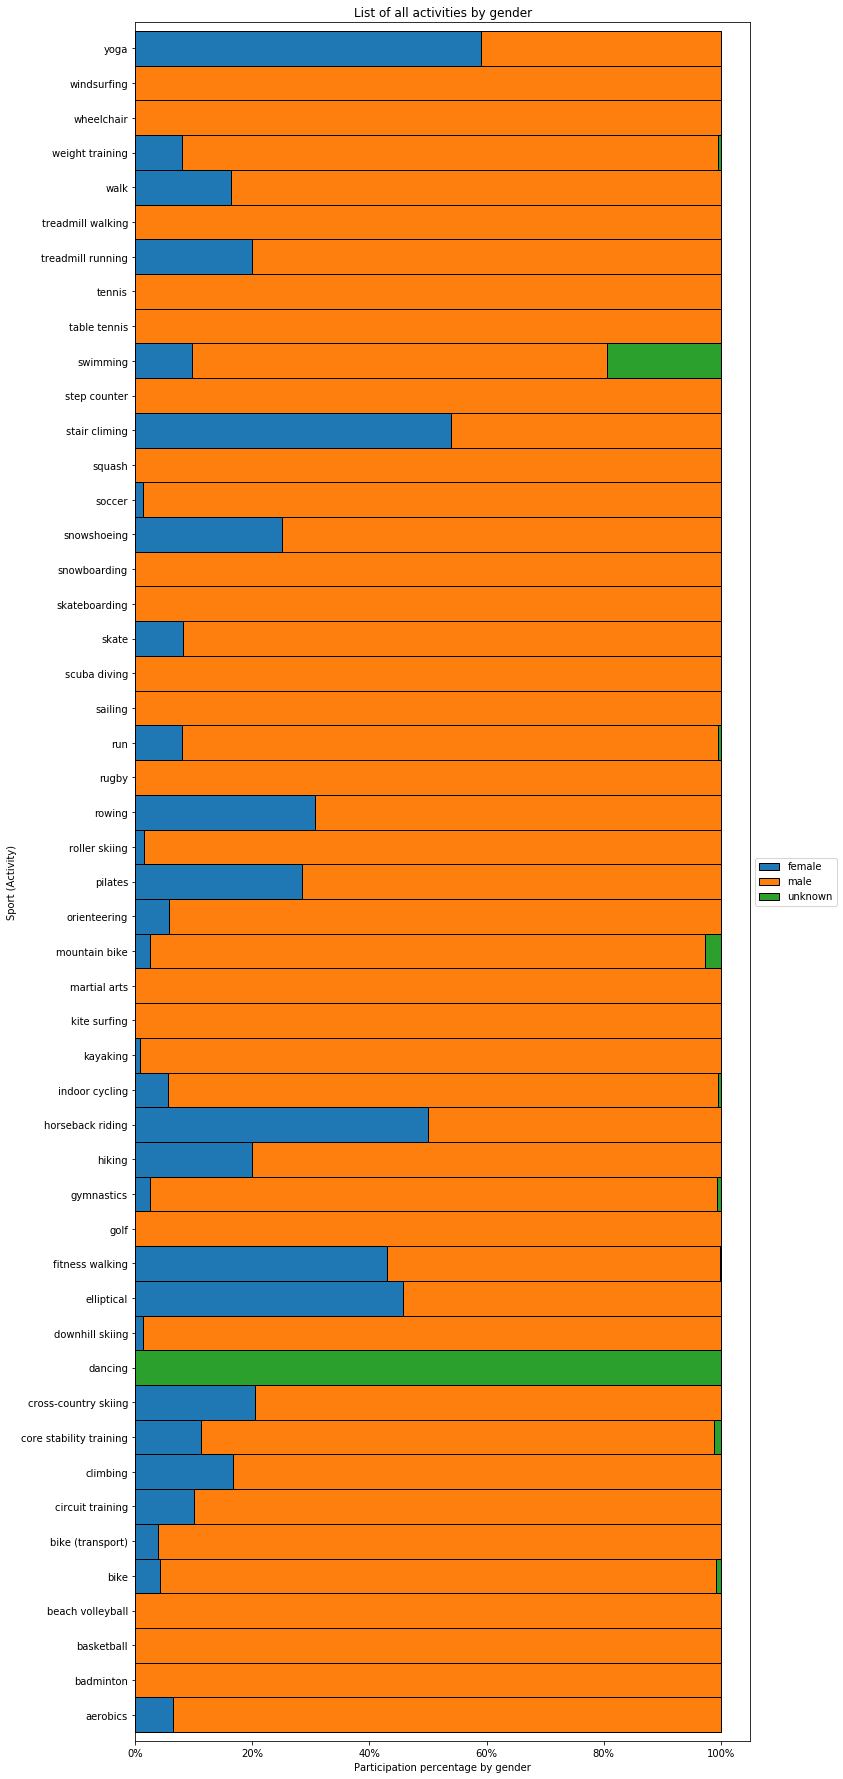

In [10]:
print('\nList of all activities:')

activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
activities_by_gender_sum = activities_by_gender.set_index(['sport','gender']).unstack(level='gender'
                                                                                      , fill_value=0).reset_index()
activities_by_gender_sum
print('\nSummarized activity participation by percentage of gender:')
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
# source1: http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot#stacked-bar-plot-with-group-by
# source2: https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1
                , edgecolor='black', ax=ax, title='List of all activities by gender');
a = plt.ylabel('Sport (Activity)');
b = plt.xlabel('Participation percentage by gender');
c = plt.legend(sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5));
d = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
e = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Let's look at the top pareto of 5 sports that have the most participation.

sport  female    male  unknown   total  percentage
0               run    9360  107882      660  117902   46.597897
1              bike    4172   92966      863   98001   38.732511
2     mountain bike     353   12782      375   13510    5.339499
3  bike (transport)     414   10030        1   10445    4.128132
5            others    1034    8255       42    9331    3.687851
4              walk     626    3204        1    3831    1.514110

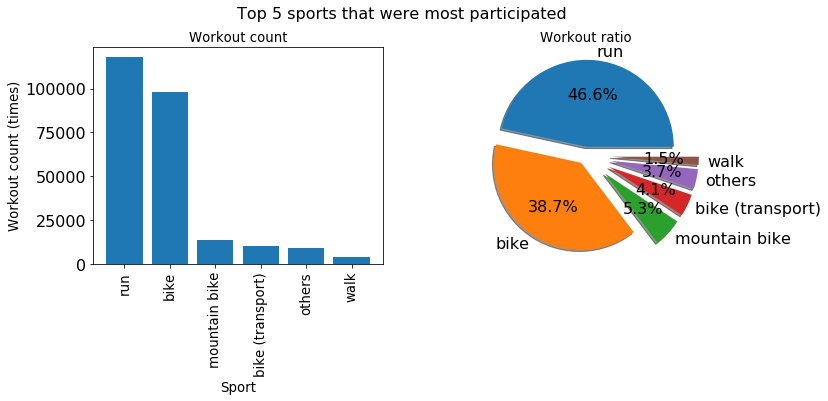

In [11]:
activities_by_gender_df = activities_by_gender.pivot_table(index="sport", 
                                                           columns="gender", values='count', fill_value=0)\
    .reset_index().rename_axis(None, axis=1)
activities_by_gender_df['total'] = activities_by_gender_df['male'] + activities_by_gender_df['female'] \
        + activities_by_gender_df['unknown']
activities_by_gender_df['percentage'] = activities_by_gender_df['total'] / sum(activities_by_gender_df['total']) * 100
top_activities_by_gender_df = activities_by_gender_df.sort_values(by='percentage', ascending=False).head(5)    
others = {'sport' : 'others'}
for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value = sum(activities_by_gender_df[column]) - sum(top_activities_by_gender_df[column])
    others.update({column: value})
top_activities_by_gender_df = top_activities_by_gender_df.append(others, ignore_index=True)
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(by='percentage', ascending=False)
top_activities_by_gender_df

#figsize = (12,6)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=top_activities_by_gender_df['sport']
                   , height=top_activities_by_gender_df['total'])
title0 = axs[0].set_title('Workout count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Workout count (times)', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport'],rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Workout ratio', fontsize = 'small')
plot1 = axs[1].pie(x=top_activities_by_gender_df['percentage'], labels=top_activities_by_gender_df['sport']
                  , autopct='%1.1f%%', shadow=True, explode=explode
                    #, pctdistance=1.2, labeldistance=1.4
                  , radius=1)

text = fig.text(0.5, 1.02, 'Top 5 sports that were most participated', ha='center', va='top', transform=fig.transFigure)

Once again, similar to the user participation, running, walking and biking are also the dominant contribution interm of number of workout counts. However, the only different is that pure running and biking activities count is much bigger than those of the remaining sports, and the total count of those 2 already take up to more than 85% of total activities of the Endomondo data set. 

* On the other way around, let's find how many people participated in more than 1 sport.

In [12]:
min_number_of_sports = 1

sport_df = df \
    .select(df.userId, df.gender, df.sport) \
    .distinct() \
    .groupBy(df.userId, df.gender) \
    .count()    

user_more_sports_df = sport_df \
                    .filter(sport_df["count"] > min_number_of_sports) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
user_more_sports_df.rename(columns = {'count':'Sports count'}, inplace = True)
user_more_sports_df.describe().astype(int)

userId  Sports count
count       822           822
mean    4860464             3
std     3953412             2
min          69             2
25%     1609606             2
50%     3730685             3
75%     7554937             5
max    15481421            16

*Based on the summary, there are 821 persons participated more than 1 sport. Among them in average a person take part in about 3 sports and there is some person playing up to 18 sports!* <br />
Now we look at the statistic by female in box plot:

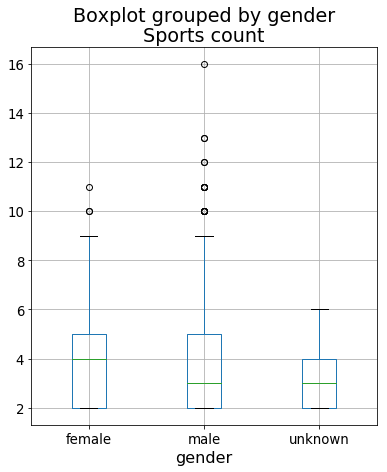

In [13]:
plot = user_more_sports_df.boxplot(column='Sports count', by='gender', fontsize='small', figsize=(6,7))


*The boxplot showed that except the outliers, both males and females have nearly the same distribution of sport participation.*

#### 5) Distribution of records count per workout

*For a more detailed observation, we break down the record count per activity into each individual sport. <br />Based on the distribution, the maximum records per workout is 500, but not all workouts and sport types reach that number.*


Plot of workouts distribution by activity type:


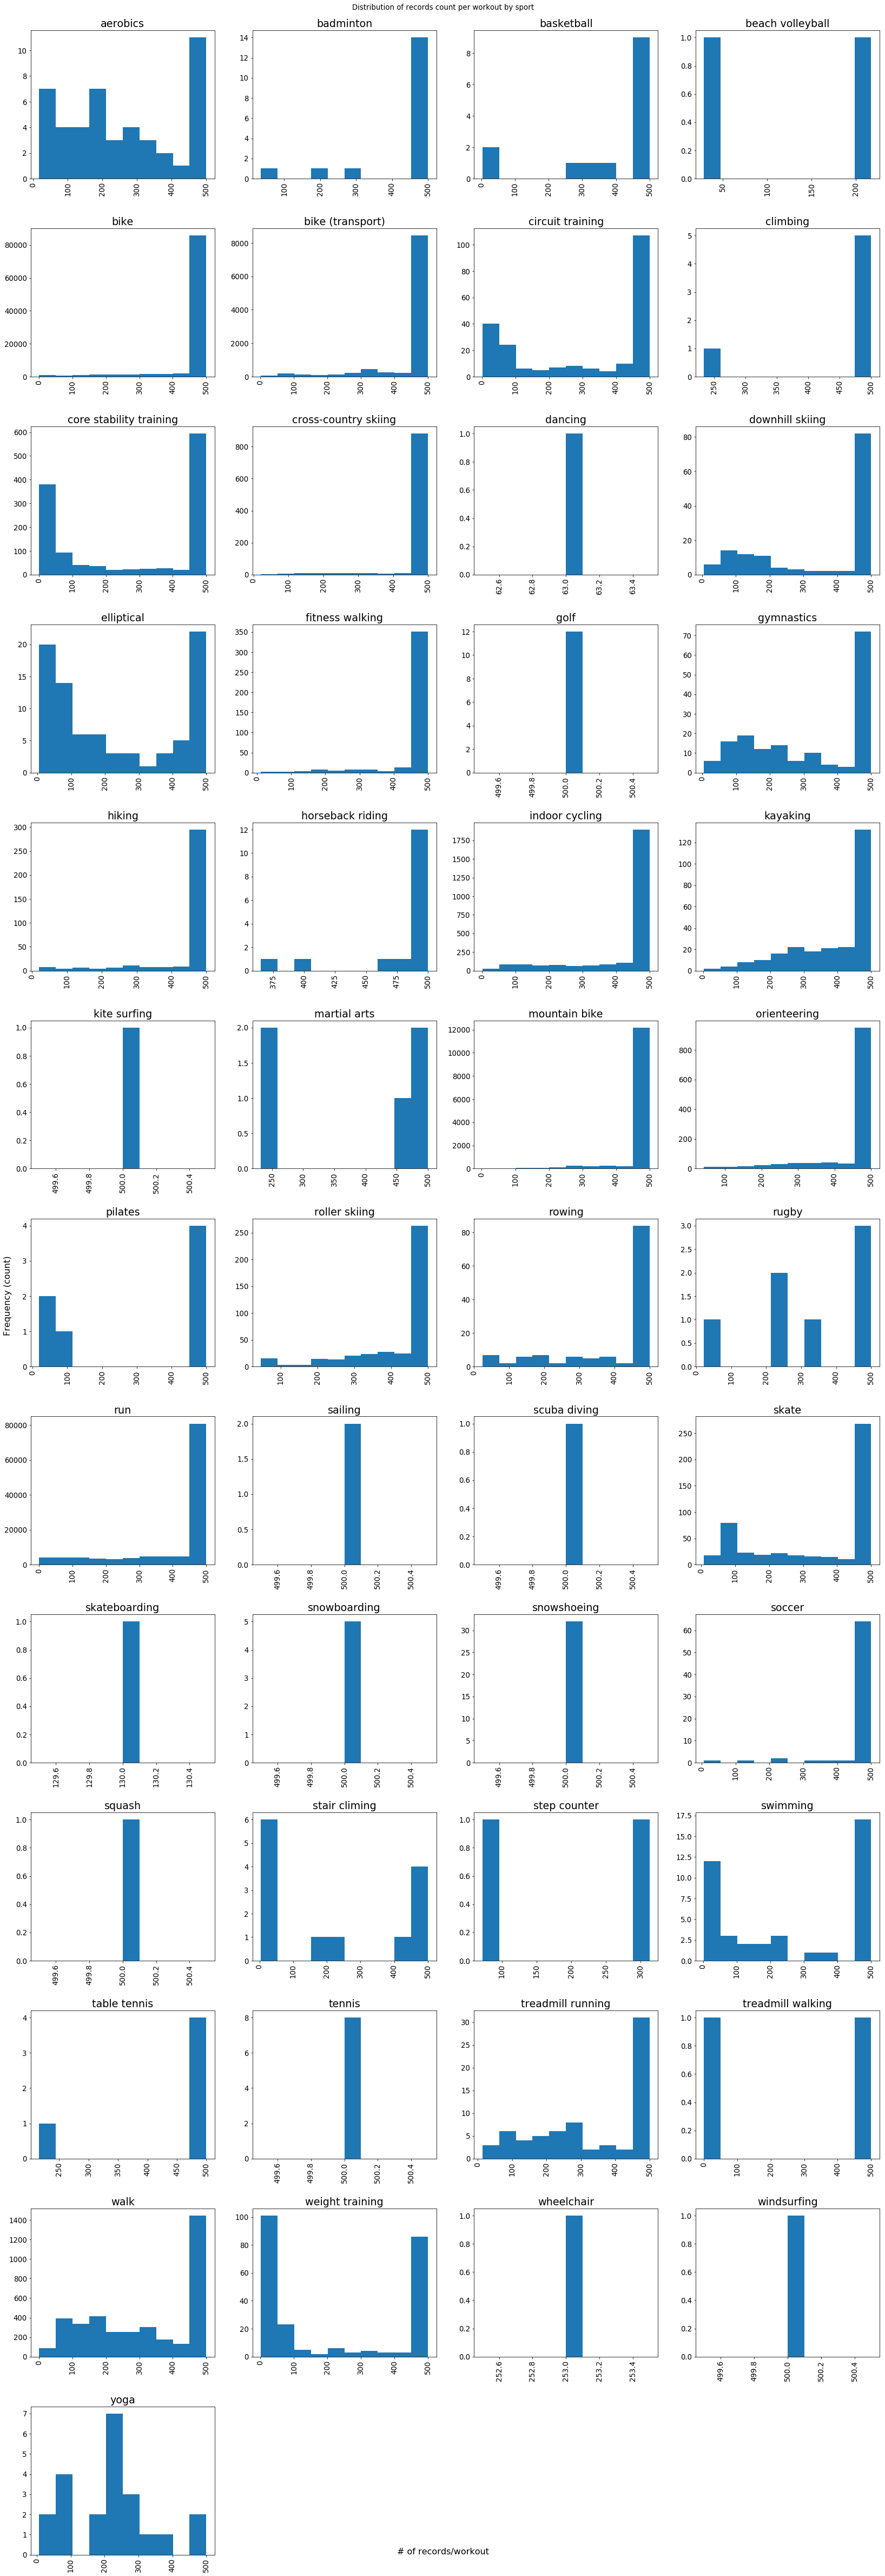

In [49]:
print('\nPlot of workouts distribution by activity type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='sport', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of records count per workout by sport', ha='center', 
         fontsize='small', transform=fig.transFigure);
xlabel = fig.text(0.5, 0.01, '# of records/workout', va='bottom', ha='center', transform=fig.transFigure);
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

- One of the aspects of interest for a fitness tracking application is prediction based on a person's workout history. This kind of feature is only workable for those who has a historical records of workout. And we only pay attentions to users with at least 10 workout records for these personalization stategies. Let's see there is how many people (users) in the data set satisfying this criteria:

In [52]:
qualified_df = df \
    .select(df.sport, df.userId, df.gender) \
    .groupBy(df.sport, df.userId, df.gender) \
    .count()
qualified_df = qualified_df.filter(qualified_df["count"] >= 10)\
    .orderBy("count", ascending = False)

In [64]:
print('Number of users having more than 10 workouts:')
qualified_pd_df = qualified_df.select("userId", "gender").distinct() \
    .groupBy(qualified_df.gender).count().toPandas()
qualified_pd_df.rename(columns={'count': 'Users count'}, inplace=True)
qualified_pd_df
qualified_users_count = sum(qualified_pd_df['Users count'])
total_users_count = df.select('userId').distinct().count()
qualified_percentage = qualified_users_count / total_users_count * 100
print('\nSo there is {} / {} of users qualifying the 10 historical records criteria, which is {:.2f}%' \
      .format(qualified_users_count, total_users_count, qualified_percentage)
     )

Number of users having more than 10 workouts:


gender  Users count
0  unknown           13
1   female           88
2     male          883


So there is 984 / 1102 of users qualifying the 10 historical records criteria, which is 89.29%


### C. It's all about TIME
Since heart rate prediction through time is a problem of time series analysis, we will need to look at the `timestamp` column carefully to understand and have a proper data preparation, as well as find hints for prediction algorithm/ technique selection.  

#### 1) Creating some derived data from `timestamp`
As seen beforem `timestamp` column contains records of timestamp series of a single workout (a data row) and is stored in UNIX timestamp format. To have more insights on this column, we will create 4 more columns from it:  
- `date_time`: Convert UNIX timestamp into python's datetime format   
*A little note is that since the Endomondo time window is different with Unix time, so in order to retrieve the proper utc time, we need to minus 7 hours from the converted datetime*
- `duration`: Total time of a single workout, in minute    
  *In order to get the workout `duration`, we get the difference between max and min of the datetime list of each workout.*
- `workout_start_time`: Determine when, which hour of the day a workout start  
  *For `workout_start_time`, it's the hour part of the first datetime record of a workout.*
- `interval`: List of time lapses between each single timestamp record in a single workout, in second   
  *And for `interval`, we will calculate it by taking the difference between 2 consecutive timestamp records within a workout.*


In [15]:
# Support function to convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register the support function 'to_time' as a user defined function into pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour\
, ''duration'' in minutes & ''interval'' in seconds), first 5 rows:')
df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()



New columns (date_time, workout_start_time in hour, duration in minutes & interval in seconds), first 5 rows:


timestamp  \
0  [1408898746, 1408898754, 1408898765, 140889877...   
1  [1408221682, 1408221687, 1408221699, 140822170...   
2  [1407858459, 1407858466, 1407858478, 140785849...   
3  [1407432042, 1407432048, 1407432056, 140743206...   
4  [1406909434, 1406909436, 1406909437, 140690943...   

                                           date_time  workout_start_time  \
0  [2014-08-24 09:45:46, 2014-08-24 09:45:54, 201...                   9   
1  [2014-08-16 13:41:22, 2014-08-16 13:41:27, 201...                  13   
2  [2014-08-12 08:47:39, 2014-08-12 08:47:46, 201...                   8   
3  [2014-08-07 10:20:42, 2014-08-07 10:20:48, 201...                  10   
4  [2014-08-01 09:10:34, 2014-08-01 09:10:36, 201...                   9   

     duration                                           interval  
0  126.483330  [8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,...  
1   74.000000  [5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,...  
2  112.483330  [7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ...  
3   75.316666  [6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1...  
4   22.616667  [2, 1, 1, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, ...

#### 2) Now, we can look at the duration of each workout (in minutes).
First is some typical statistics.

In [16]:
print('\nLet''s look at the statistics of the new duration column (in minutes):')
df.select('duration').toPandas().describe()


Lets look at the statistics of the new duration column (in minutes):


duration
count  253020.000000
mean       84.486427
std        98.093048
min         0.000000
25%        32.166668
50%        58.916668
75%       102.733330
max      1439.966675

From the statistic of `duration` column, it can be observed that workout duration can last from 0 minute and up to 1 full day (1440 minutes = 24 hours, and this extreme is only observed on the sport *'orienteering'*). The duration of 0 might be for workouts that only have 1 single record only, so the min and the max timestamp would be the same.<br />
Now it's plot time for duration:



Plotting distribution of duration per sport type:


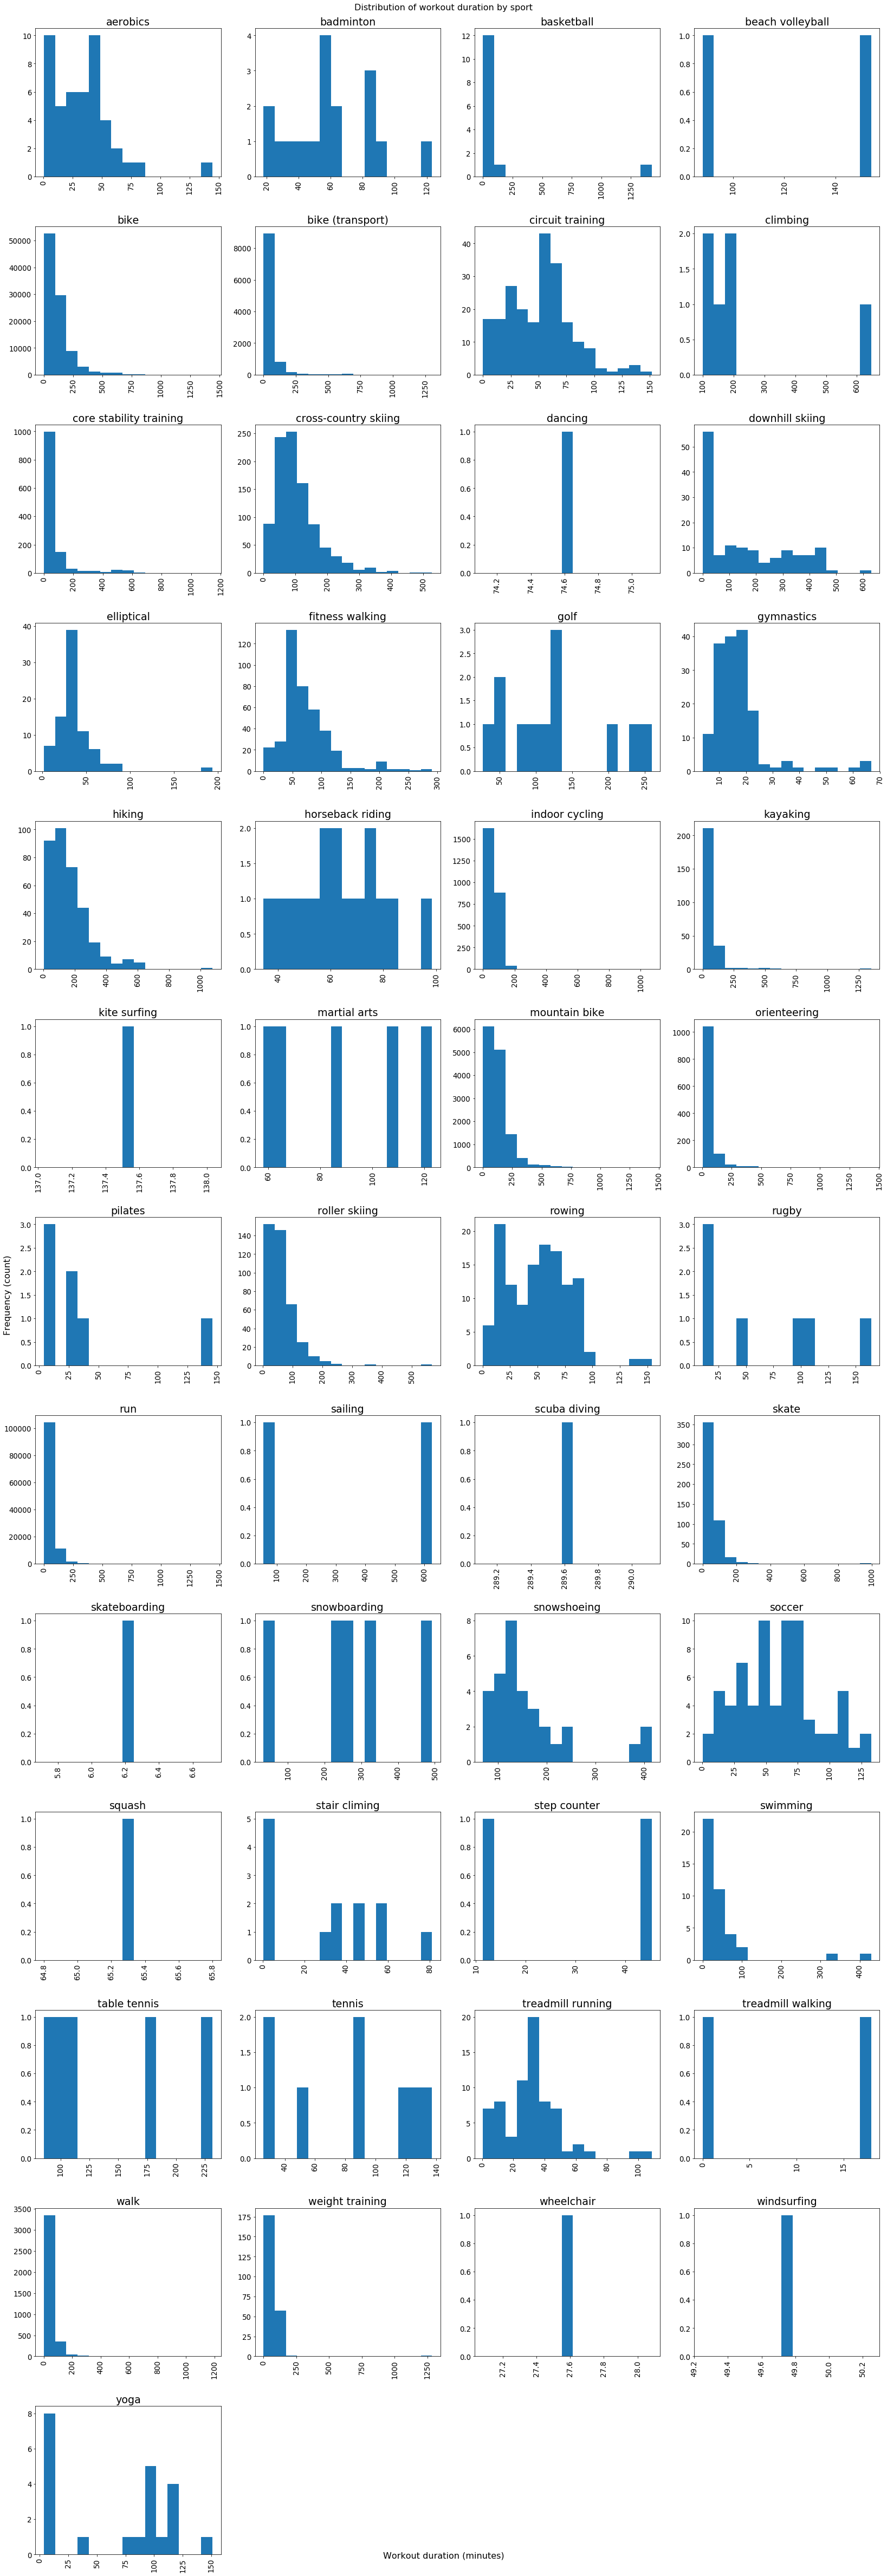

In [47]:

print('\nPlotting distribution of duration per sport type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
figsize = (figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', by='sport', bins=15, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small' , ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of workout duration by sport'
             , ha='center', va='center', transform=fig.transFigure
            )
xlabel = fig.text(0.5, 0.01, 'Workout duration (minutes)'
             , ha='center', va='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical')

*From the duration summary & distribution plot, majority of the activities happens in 1-2 hours, only a few sports with a few cases each type happened in longer durations, such as moutain bike, hiking, sailing, etc..*

#### 2) Workout records' intervals:
After `duration`, next we look at the `interval` column and have some statistics for it. Since the full list of interval is too large to have the boxplot (the best type of chart in *Matplotlib* for statistic description), we were only able to calculate the major statistics (min/max/mean/average/standar deviation and 4 quantiles 25th/50th/75th/95th) info in pySpark and plot them.

In [18]:
# Helper function to calculate statistic(s) of the column name from a tuple x of (sport, records list of the column)
#, the stats to calculate is also given as an input
def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

def retrieve_array_column_stat_df(df, column_name, stat_list):
    # Convert sport & "column_name" to RDD to easily calculate the statistics of intervals by sports
    sport_record_rdd = df.select('sport', column_name).rdd.map(tuple).combineByKey(to_list, extend, extend).persist()

    # Calculate statistics of the input column by calling calculate_stats function defined above
    record_statistic_df = pd.DataFrame(sport_record_rdd.map(lambda x: calculate_stats(x, column_name,stat_list)).collect())
    # Set proper dataframe column orders
    columns_order = ['sport'] + [stat + ' ' + column_name for stat in stat_list]
    # Re order columns
    return record_statistic_df[columns_order]

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
                     '75th percentile', '95th percentile', 'max', 'stdev']
interval_statistic_df = retrieve_array_column_stat_df(df, column_name='interval', stat_list=stat_list)
print('\nLet\'s look at statistic for interval, in seconds (by sport):' )
interval_statistic_df


Let's look at statistic for interval, in seconds (by sport):


sport  min interval  25th percentile interval  \
0                      walk             0                       3.0   
1                      yoga             0                       3.0   
2         treadmill running             0                       2.0   
3          bike (transport)             0                       3.0   
4                    soccer             0                       4.0   
5                  kayaking             0                       5.0   
6                      bike             0                       5.0   
7                      golf             0                       6.0   
8                    squash             2                       6.0   
9                    rowing             0                       4.0   
10             snowboarding             1                      11.0   
11         beach volleyball             0                      12.0   
12                      run             0                       4.0   
13                  pilates             1                       3.0   
14                   tennis             1                       5.0   
15            skateboarding             1                       1.0   
16             table tennis             1                       8.0   
17               gymnastics             0                       1.0   
18            roller skiing             0                       3.0   
19            stair climing             0                       3.0   
20             kite surfing            16                      16.0   
21             step counter             1                       7.0   
22              windsurfing             3                       3.0   
23             scuba diving            10                      21.0   
24               wheelchair             1                       4.0   
25                  sailing             1                       6.0   
26        treadmill walking             0                       2.0   
27               elliptical             0                       3.0   
28          weight training             0                       3.0   
29                 climbing             3                      14.0   
30          downhill skiing             0                       6.0   
31             orienteering             0                       5.0   
32                  dancing             2                      20.0   
33                 swimming             1                       3.0   
34     cross-country skiing             0                       6.0   
35                badminton             0                       4.0   
36             martial arts             0                       6.0   
37         horseback riding             0                       4.0   
38          fitness walking             0                       5.0   
39               basketball             1                       3.0   
40                    rugby             1                       3.0   
41                 aerobics             0                       3.0   
42         circuit training             0                       3.0   
43           indoor cycling             0                       5.0   
44                   hiking             0                       8.0   
45              snowshoeing             1                       9.0   
46            mountain bike             0                       6.0   
47  core stability training             0                       3.0   
48                    skate             0                       3.0   

    mean interval  50th percentile interval  75th percentile interval  \
0        7.912633                       5.0                      8.00   
1       18.114438                       7.0                     19.00   
2        5.513624                       4.0                      6.00   
3        8.529853                       5.0                      8.00   
4        7.579923                       6.0                      9.00   
5       11.859714                

Now we plot those numbers in bar (for quantiles statistics) and line charts (for min/max/mean/stdev) for a more visualized feel.  
*Note: Due to the fact that the maximum interval and stdev have a much higher order of magnitude compared to the remaining columns, we need to put those 2 columns in a separate y axis on the right.*


Summarize statistics of interval sport:


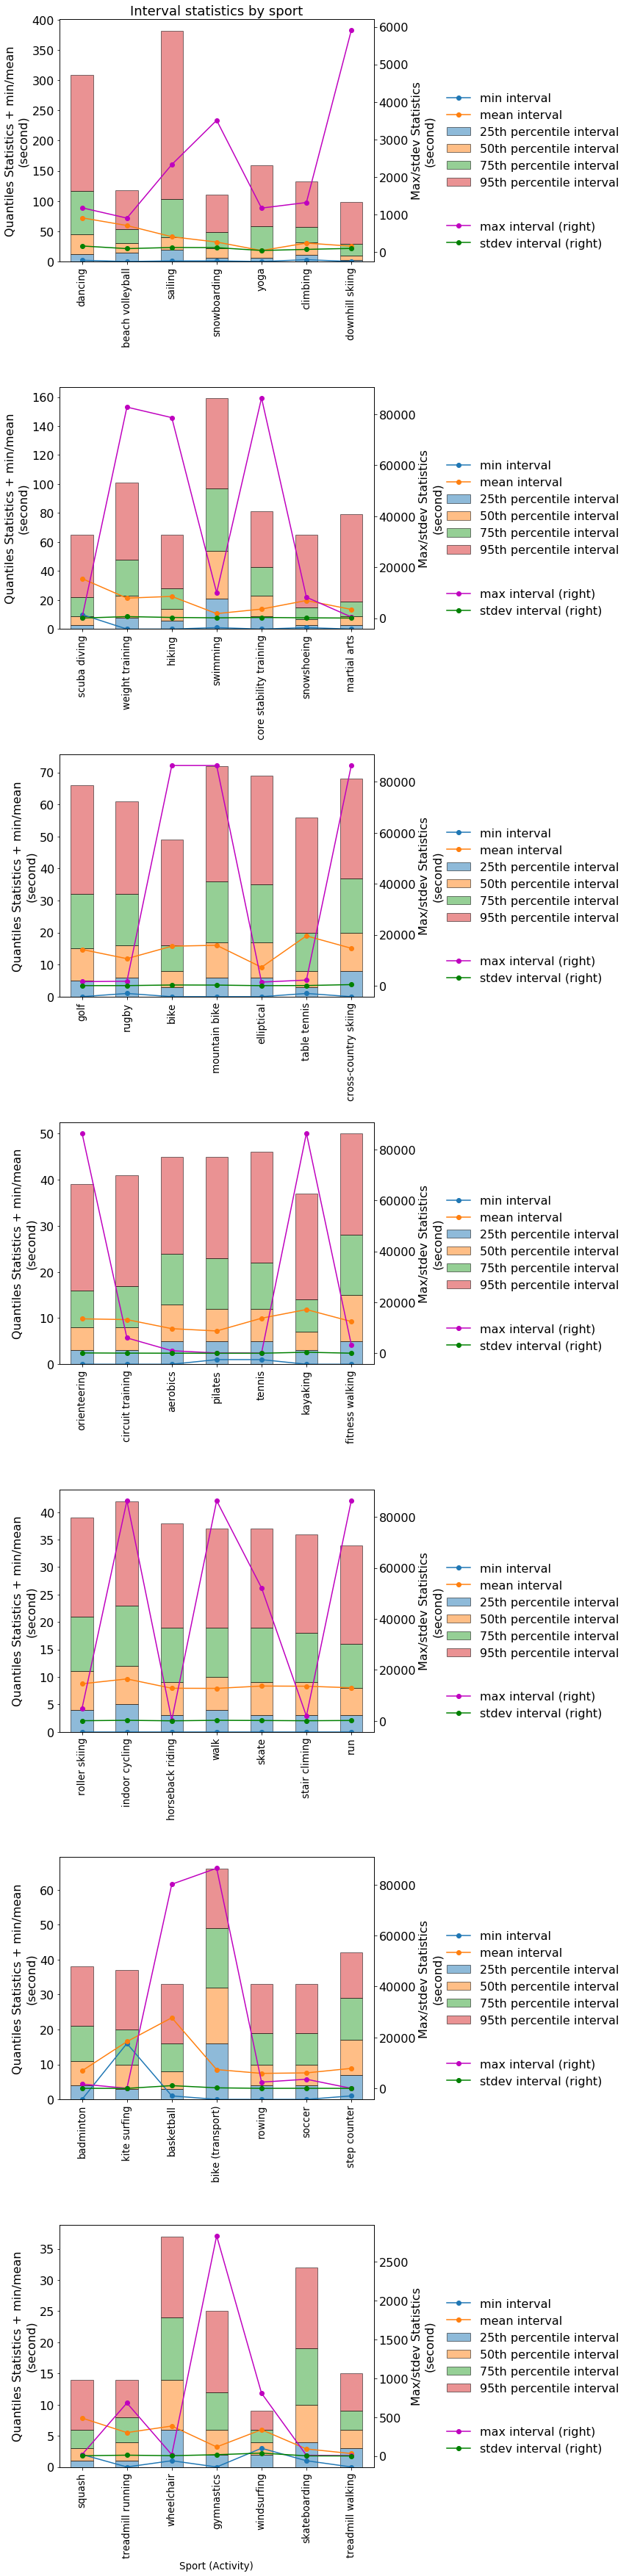

In [19]:
print('\nSummarize statistics of interval sport:')
bar_columns = ['25th percentile interval', '50th percentile interval', '75th percentile interval', '95th percentile interval']
line_columns1 = ['min interval', 'mean interval'] 
line_columns2 = ['max interval', 'stdev interval'] 
interval_statistic_df = interval_statistic_df.sort_values(by='95th percentile interval', ascending=False)
figsize=(13, 49)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title('Interval statistics by sport', fontsize=18)
for i in range (7):
    interval_statistic_sub_df = interval_statistic_df.iloc[i*7:i*7+7,]
    #interval_statistic_sub_df
    plot1 = interval_statistic_sub_df[['sport'] + bar_columns].groupby(['sport']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = interval_statistic_sub_df[['sport'] + line_columns1].plot(x='sport', ax=axs[i], marker='o');
    ax2 = axs[i].twinx()
    plot3 = interval_statistic_sub_df[['sport'] + line_columns2].plot(x='sport', ax=ax2, marker='o', color=['m', 'g']);
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(interval_statistic_sub_df['sport'],rotation = 'vertical', fontsize='small')
    c = axs[i].set_xlabel('Sport (Activity)', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(second)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(second)', fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label.set_fontsize(16) 
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

a = fig.tight_layout()
plt.show()


Looking at the quantiles statistic, up to 95% of the interval data set does not have the interval larger than 400 columns, while there are just a few outliers that made the maximum intervals reach up to 86400 (a full days). This is probably due to Edomondo data record issues.  

#### 7) Workout start time
Once again, we use histogram chart to look at the distribution of workouts' started hours, grouped by sport and broken down by gender. We divide a day into intervals of 2 hours, so there are totally 12 buckets. 

In [20]:
# Retrive the table of gender, sport and workout_start_time for plotting
start_time_df = df.select('gender', 'sport','workout_start_time').toPandas()


Plotting distribution of workout start time per sport type, break down by gender:


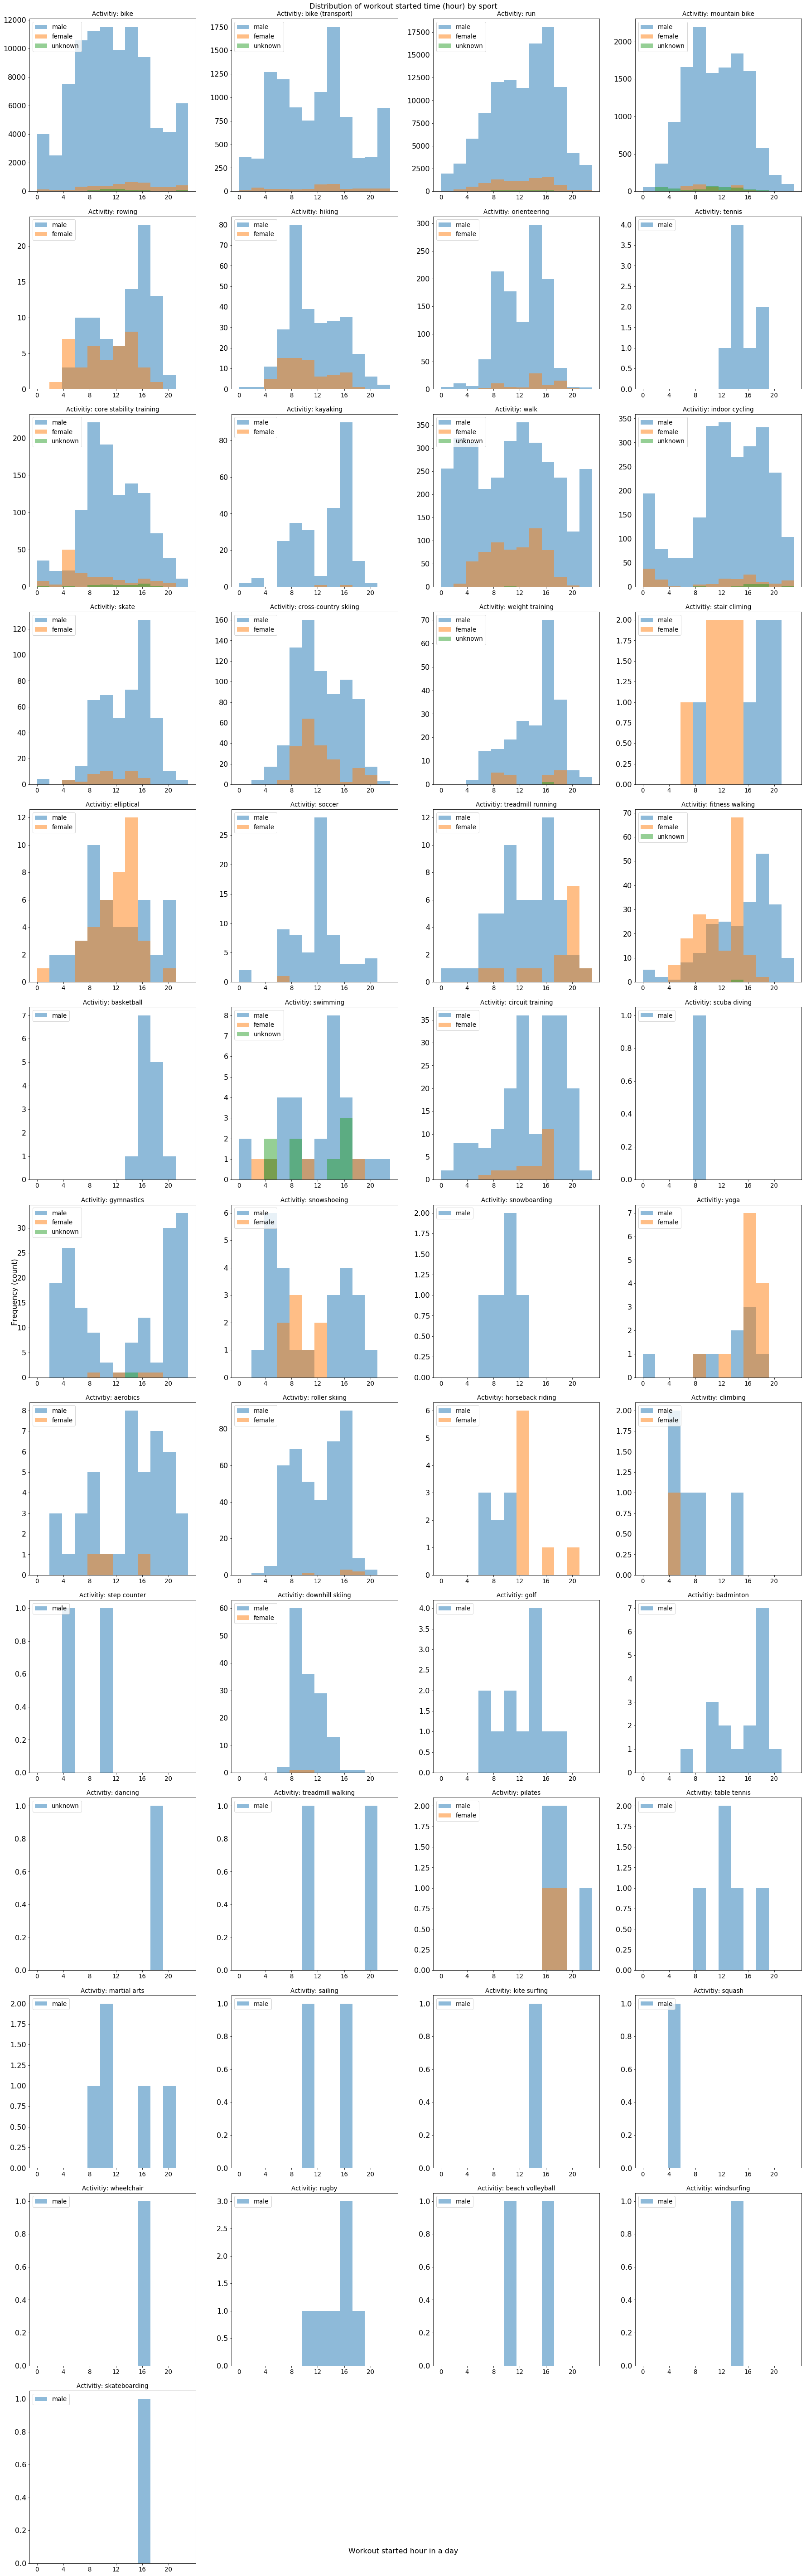

In [21]:
activities = start_time_df['sport'].unique()
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = (plot_size_x + 0.5) * 4 +3, (plot_size_y + 1) * 13 + 1
#a = plt.figure(figsize=(figsize_x, figsize_y)) 

nrows, ncols = 13, 4
a = fig.subplots_adjust(hspace = 1, wspace = 1)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_x, figsize_y))
print('\nPlotting distribution of workout start time per sport type, break down by gender:')
a = plt.setp(axs, xticks=[0, 4, 8, 12, 16, 20])
for index, sport in enumerate(activities):
    row_index, col_index = divmod(index, ncols)
    male_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'male')]['workout_start_time']
    female_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'female')]['workout_start_time']
    unknown_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'unknown')]['workout_start_time']
    if len(male_start_time_list) > 0:
        male_dist = axs[row_index, col_index].hist(male_start_time_list,
                                      bins = 12, alpha=0.5, label='male', range=(0, 23))
    if len(female_start_time_list) > 0:    
        female_dist = axs[row_index, col_index].hist(female_start_time_list,
                                      bins = 12, alpha=0.5, label='female', range=(0, 23))
    if len(unknown_start_time_list) > 0:
        unknown_dist = axs[row_index, col_index].hist(unknown_start_time_list,
                                      bins = 12, alpha=0.5, label = 'unknown', range=(0, 23))
    b= axs[row_index, col_index].set_title('Activitiy: ' + sport, fontsize='small')
    a = axs[row_index, col_index].legend(loc="upper left", fontsize='small')
    a = plt.setp(axs[row_index, col_index].get_xticklabels(), fontsize='small')

for i in range(1,4):
    x = axs[12, i].set_visible(False)
a = fig.tight_layout()
z = fig.text(0.5, 1, 'Distribution of workout started time (hour) by sport'
             , ha='center', va='top', transform=fig.transFigure)
y = fig.text(0.5, 0.01, 'Workout started hour in a day', ha='center', va='bottom', transform=fig.transFigure)
z = fig.text(0.02, 0.5, 'Frequency (count)', va='center', rotation='vertical')

From the distribution charts above, it can be seen that most of the sports have activities started either in the morning or eveneing (bimodal distribution), which does make sense. There are a few activities happening during the timeframe of 0-4 o'clock, which is quite odd.  
<br />

### D. Look deeper into row level information
#### 1) First we have an overview on statistics of heart rate to see if there is any abnormality in data

In [22]:
stat_list = ['min', '25th percentile', 'mean', '95th percentile', 'max', 'stdev']
heart_rate_statistic_df = retrieve_array_column_stat_df(df, column_name='heart_rate', stat_list=stat_list)

In [23]:
print('\nLet\'s look at statistic for heart rate, in bpm (by sport):' )
heart_rate_statistic_df


Let's look at statistic for heart rate, in bpm (by sport):


sport  min heart_rate  25th percentile heart_rate  \
0                      walk               0                       92.00   
1                      yoga              45                       74.00   
2         treadmill running              56                      139.00   
3          bike (transport)            -865                      113.00   
4                    soccer              68                      131.00   
5                  kayaking              45                      105.00   
6                      bike           -1320                      118.00   
7                      golf              54                       79.00   
8                    squash             102                      138.00   
9                    rowing              44                      117.00   
10             snowboarding              54                       84.00   
11         beach volleyball              78                      125.25   
12                      run           -2604                      136.00   
13                  pilates              52                       76.00   
14                   tennis              71                      112.00   
15            skateboarding             112                      125.00   
16             table tennis              48                       79.00   
17               gymnastics              40                       97.00   
18            roller skiing              54                      115.00   
19            stair climing              38                      111.00   
20             kite surfing              76                      143.00   
21             step counter              89                      101.00   
22              windsurfing             104                      122.00   
23             scuba diving              97                      143.00   
24               wheelchair              60                       74.00   
25                  sailing              61                       81.00   
26        treadmill walking              96                      178.00   
27               elliptical              60                      122.00   
28          weight training              46                       95.00   
29                 climbing              80                      117.00   
30          downhill skiing               0                       73.00   
31             orienteering           -1200                      136.00   
32                  dancing              78                       98.00   
33                 swimming              37                      106.00   
34     cross-country skiing               0                      122.00   
35                badminton              76                      126.00   
36             martial arts              55                       87.00   
37         horseback riding              67                      125.00   
38          fitness walking              41                      100.00   
39               basketball              57                      104.00   
40                    rugby              72                      115.00   
41                 aerobics              62                      119.00   
42         circuit training              24                      103.00   
43           indoor cycling               0                      121.00   
44                   hiking               0                       93.00   
45              snowshoeing              49                      105.00   
46            mountain bike            -445                      119.00   
47  core stability training               0                      102.00   
48                    skate               0                      108.00   

    mean heart_rate  95th percentile heart_rate  max heart_rate  \
0        104.877308                      143.00             251   
1         92.681094                      202.00             217   
2        149.158980                      175.00             233   
3  

Based on this statistic and knowledge about heart rate that it is only within range of 25 - 250, **we will remove all the records with heart rate < 25 and > 260** [1]

#### 2) Next, we will have a first look at the heart rate for each workout.

*Due to the huge amount of users and workout numbers, we just picked randomly up to a x number of users per gender (ex, 5), and up to y workouts per activity type (ex, 10).<br />*

In [24]:
# Support function helping to sample data
def sampling_data(max_users_per_gender, max_workouts_per_sport):
    '''
        max_users_per_gender: maximum number of user to be selected randomly per gender
        max_workouts_per_sport: maximum number of activities to be selected per sport (the sports existing in selected users)
    '''
    # Get unique list of userId and gender, for sampling purpose
    users_genders = df.select('userId', 'gender').distinct().toPandas()
    # Use 'sample' function to pick up to 3 userId per gender from the unique userId list
    random_x_users_per_gender = users_genders.groupby('gender')['userId'].apply(
                lambda s: s.sample(min(len(s), max_users_per_gender))
    )

    # Apply filter on the main pyspark dataframe for sampling
    samples_by_gender = df.where(df.userId.isin(list(random_x_users_per_gender)))

    # Next, generate the unique activity ids and sport types list from the sampled data set 
    workout_sports = samples_by_gender.select('id', 'sport').distinct().toPandas()
    # Use 'sample' function to pick up to 10 activity ids for each kind of sport 
    random_y_workouts_per_sport = workout_sports.groupby('sport')['id'].apply(
        lambda s: s.sample(min(len(s), max_workouts_per_sport))
    )

    # Apply filter to the sampled dataset to continue reduce the number of workouts per activity type
    samples_by_gender_and_sport = samples_by_gender.where(df.id.isin(list(random_y_workouts_per_sport)))
    return samples_by_gender_and_sport

In [25]:
# Use 2 variable to determine the sampling criteria: maximum users per gender and maximum workouts per sport
max_users_per_gender, max_workouts_per_sport = 20, 15
# Collect the sampled data set to Pandas to be used with plot features
pd_df = sampling_data(max_users_per_gender, max_workouts_per_sport).toPandas()
print('\nSampled data overview (only string and numeric columns):')
pd_df.describe()


Sampled data overview (only string and numeric columns):


id        userId  PerWorkoutRecordCount  workout_start_time  \
count  2.090000e+02  2.090000e+02             209.000000          209.000000   
mean   3.529752e+08  4.098476e+06             407.669856           11.363636   
std    1.373479e+08  2.559776e+06             144.359597            4.861724   
min    3.578680e+07  3.686030e+05               6.000000            3.000000   
25%    2.446338e+08  1.483178e+06             317.000000            7.000000   
50%    3.823949e+08  4.439016e+06             500.000000           11.000000   
75%    4.332912e+08  5.032597e+06             500.000000           16.000000   
max    6.450664e+08  1.269419e+07             500.000000           23.000000   

         duration  
count  209.000000  
mean   102.464432  
std    128.735718  
min      0.800000  
25%     34.433334  
50%     60.633335  
75%     96.966667  
max    628.799988

All sampling have been done, let's plot heart rate on the sample data set! <br />
*Note: from this first look, the heart rate and workout time of a day is quite varied per user and activity.<br />
In the first plot, we keep the original datetime value, but the result could not give much meaning since the activities of all users happened at different timeframes.<br />
In the second plot, we convert the datetime to time value (hour: minute: second) to use for the plot so all heart rate trends only vary within the 24 hours of a day. This second plot has a limitation that it will not display correctly the workouts that last from 1 night to the next day.*

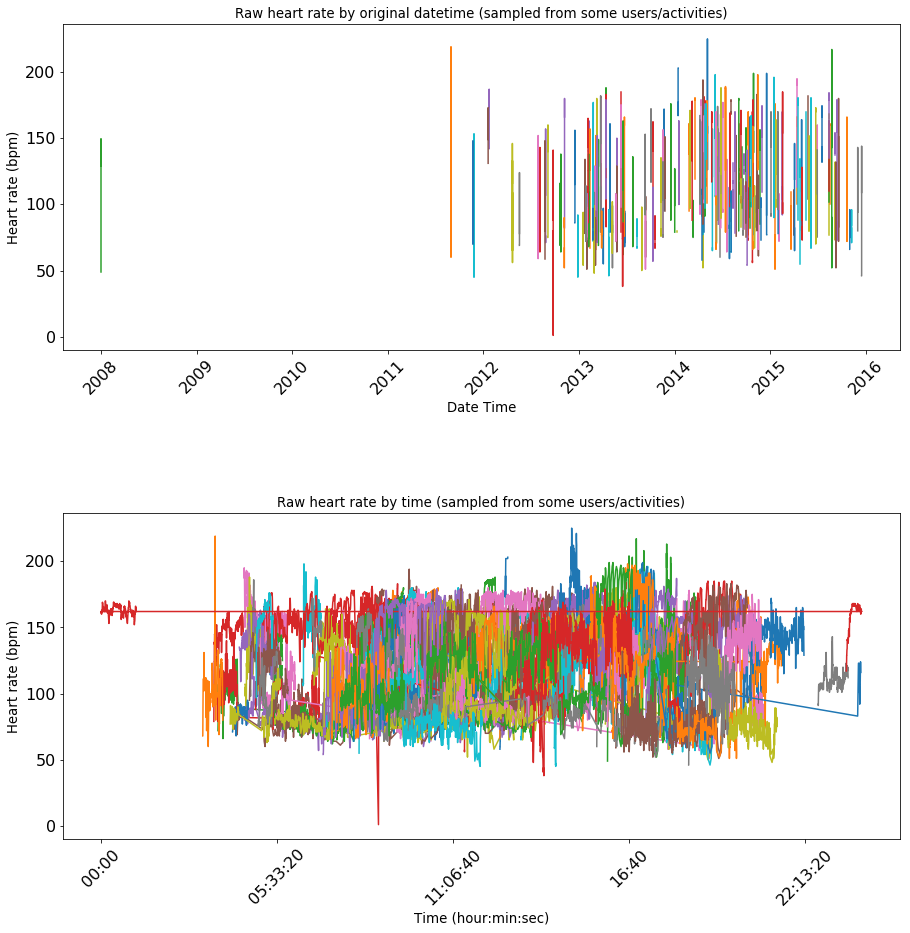

In [26]:
fig, axs = plt.subplots(2, figsize=(15, 15))
#fig = plt.figure(figsize=(20, 10))
a = fig.subplots_adjust(hspace = 0.5)
pd_df_temp = pd_df
for index,data_row in pd_df_temp.iterrows():
    #data_row['date_time'] = [date_time.time() for date_time in data_row['date_time']]
    label = 'user: ' + str(data_row['userId']) + ' - sport: ' + data_row['sport']
    a= axs[0].plot(data_row['date_time'], data_row['heart_rate'], label=label)
    # Convert datetime to time to plot the second chart:
    data_row['date_time'] = [date_time.time() for date_time in data_row['date_time']]
    b= axs[1].plot(data_row['date_time'], data_row['heart_rate'], label=label)
a = axs[0].set_title('Raw heart rate by original datetime (sampled from some users/activities)',fontsize='small')
a = axs[1].set_title('Raw heart rate by time (sampled from some users/activities)',fontsize='small')
#d = c.set_rotation(45)
b = plt.setp(axs[0].get_xticklabels(), rotation=45)
b = plt.setp(axs[1].get_xticklabels(), rotation=45)
#b = plt.xticks(rotation='vertical', fontsize='small')
#c = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 8})
a= axs[0].set_ylabel('Heart rate (bpm)', fontsize='small')
a= axs[1].set_ylabel('Heart rate (bpm)', fontsize='small')
b= axs[0].set_xlabel('Date Time', fontsize='small')
b= axs[1].set_xlabel('Time (hour:min:sec)', fontsize='small')


*Even from the 2 messy plots above, we can see there are some record with zero heart rate and some workouts have missing data in the middle. The step to remove workouts containing zero hear rate was already included in filtering step [1] at the begining.*

<br />

#### 2) Continue looking on a normalized timestamp

*The plot above still did not give a good visualization of heart rate. So next step, we will need to normalize the time for all workouts by calulating the duration (in seconds) of each timestamp record from the first record of a workout (the first datetime element of the list in that workout). <br />
Then we plot the heart rate on this normalized time, grouping by sport.*

New normalized datetime (first 7 rows):


userId            sport  \
0  9613679  weight training   
1  6670535              run   
2  5269471  weight training   
3  8372595              run   
4  7957303   indoor cycling   
5  7957303   indoor cycling   
6  7957303   indoor cycling   

                                           date_time  \
0  [2013-04-29 17:30:42, 2013-04-29 17:30:44, 201...   
1  [2014-03-19 10:14:33, 2014-03-19 10:14:34, 201...   
2  [2013-12-17 18:00:16, 2013-12-17 18:00:17, 201...   
3  [2013-10-09 03:34:04, 2013-10-09 03:34:07, 201...   
4  [2014-06-16 17:39:30, 2014-06-16 17:39:33, 201...   
5  [2014-05-02 18:14:32, 2014-05-02 18:14:33, 201...   
6  [2014-04-27 17:26:30, 2014-04-27 17:26:33, 201...   

                                normalized_date_time  
0  [0, 2, 5, 12, 22, 31, 40, 43, 53, 62, 72, 78, ...  
1  [0, 1, 3, 5, 7, 8, 10, 12, 14, 16, 18, 21, 25,...  
2  [0, 1, 14, 23, 34, 54, 59, 62, 66, 80, 106, 10...  
3  [0, 3, 6, 7, 9, 19, 22, 26, 28, 35, 40, 42, 49...  
4  [0, 3, 5, 9, 12, 16, 20, 23, 31, 40, 53, 71, 7...  
5  [0, 1, 3, 4, 8, 9, 10, 14, 18, 28, 32, 33, 34,...  
6  [0, 3, 5, 7, 11, 21, 25, 33, 45, 52, 61, 71, 8...


Plot raw heart rate (sampled) by normalized time:


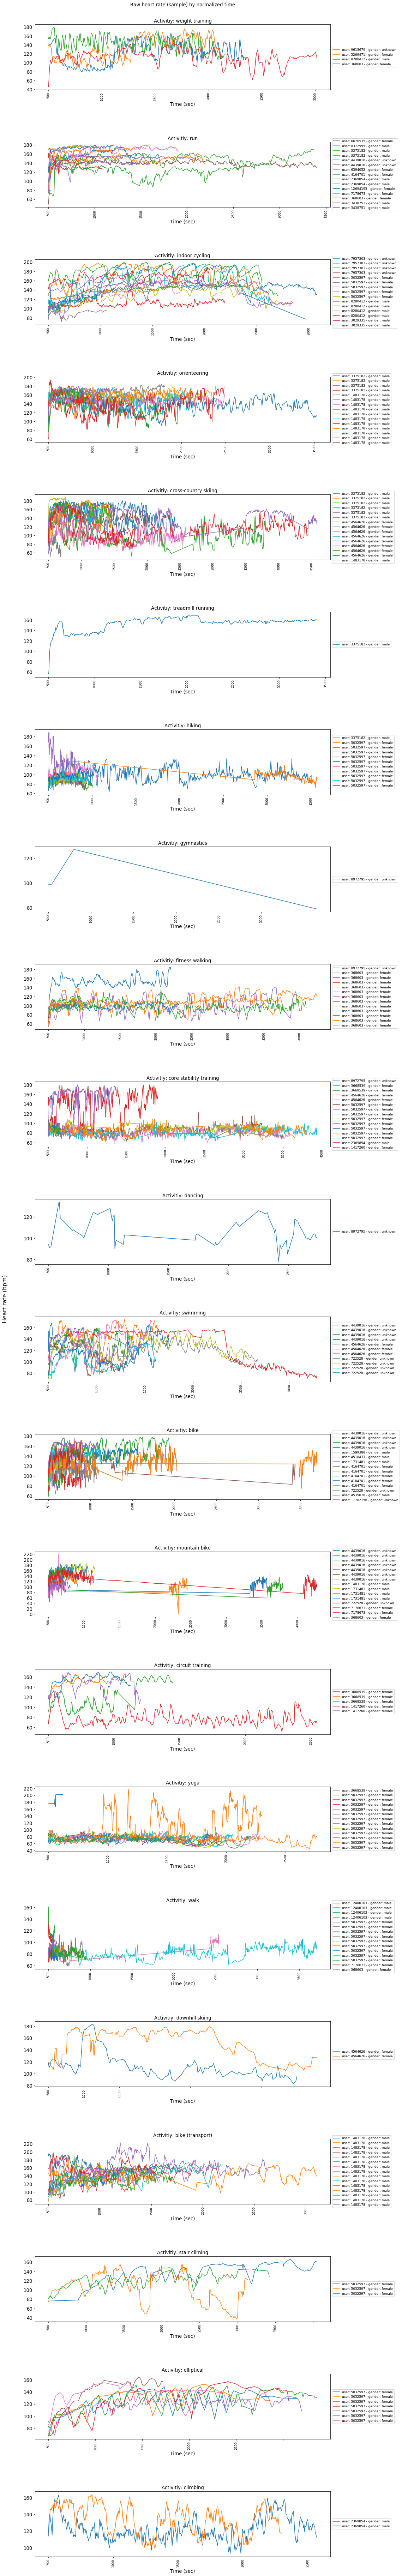

In [27]:
# Lambda function to flatten a list of lists into a big single list
flattern = lambda l: set([item for sublist in l for item in sublist])

normalized_datetime_list = []
for index,data_row in pd_df.iterrows():
    min_date_time = min(data_row['date_time'])
    normalized_datetime_list.append([(date_time - min_date_time).seconds for date_time in data_row['date_time']])

pd_df['normalized_date_time'] = normalized_datetime_list

print('New normalized datetime (first 7 rows):')
pd_df.head(7)[['userId', 'sport', 'date_time','normalized_date_time']]

print('\nPlot raw heart rate (sampled) by normalized time:')

sport_list = pd_df['sport'].unique()
# Define the length of the figure dynamically depends on the length of the sport list
fig, axs = plt.subplots(len(sport_list), figsize=(15, 6*len(sport_list)))
a = fig.subplots_adjust(hspace = 0.8)
c = plt.setp(axs, yticks=range(0,250,20))

for sport_index, sport in enumerate(sport_list):
    workout = pd_df[pd_df.sport == sport]
    max_time = max(flattern(workout.normalized_date_time))
    for workout_index, data_row in workout.iterrows():
        label = 'user: ' + str(data_row['userId']) + ' - gender: ' + data_row['gender']
        a= axs[sport_index].plot(data_row['normalized_date_time'], data_row['heart_rate'], label=label)
    b= axs[sport_index].set_title('Activitiy: ' + sport, fontsize='small')
    b= axs[sport_index].set_xlabel('Time (sec)', fontsize='small')
    a = axs[sport_index].set_xticklabels(range(0, max_time, 500),rotation = 'vertical', fontsize=9)
    b = axs[sport_index].set_yticklabels(range(0,250,20),fontsize='small')
    c = axs[sport_index].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 9})

z =fig.text(0.04, 0.5, 'Heart rate (bpm)', va='center', rotation='vertical')
z =fig.text(0.5, 1.3, 'Raw heart rate (sample) by normalized time', 
            ha='center', va='center', fontsize='small', transform=axs[0].transAxes)


### E. Workout displacements
We will have some visualization on 3 displacement/geometry info columns (`longitude`,`latitude` & `altitude`).    
Since the geometry location of each user and workout is different from each others, we only plot a few single workouts in 3D plots to have a look on the workout route.


In [28]:
pd_df_small = sampling_data(max_users_per_gender=2, max_workouts_per_sport=2).toPandas()
print('Sampled data (2 user, 2 workouts per sport):')
pd_df_small[['userId', 'gender','sport','id', 'workout_start_time'
             ,'PerWorkoutRecordCount', 'duration', 'longitude', 'latitude', 'altitude']]

Sampled data (2 user, 2 workouts per sport):


userId   gender                    sport         id  workout_start_time  \
0      56291     male        treadmill running  632436711                   8   
1      56291     male        treadmill running  578961713                  15   
2      56291     male                      run   91048597                  15   
3    7957303  unknown           indoor cycling  336701503                  18   
4    7957303  unknown           indoor cycling  328352971                  17   
5   13840816   female         bike (transport)  383011698                   7   
6   13840816   female         bike (transport)  347192699                  17   
7    4439016  unknown                 swimming  395240820                  17   
8    4439016  unknown                 swimming  395244803                  17   
9    4439016  unknown                     bike  395297857                  12   
10   4439016  unknown            mountain bike  395324154                   3   
11   4439016  unknown                     bike  395341410                   9   
12   4439016  unknown  core stability training   67821301                  15   
13   4439016  unknown  core stability training   67821318                  17   
14   4439016  unknown            mountain bike  395375673                  12   
15   4439016  unknown                      run  395707748                   9   
16   1818866   female                   hiking  363421091                   8   
17   1818866   female            roller skiing  323470184                  16   
18   1818866   female     cross-country skiing  319380685                   9   
19   1818866   female                   hiking  205198091                  16   
20   1818866   female             orienteering  188414370                  13   
21   1818866   female                     walk  162399522                  15   
22   1818866   female                     walk  161842422                  14   
23   1818866   female     cross-country skiing  161598722                   9   
24   1818866   female         horseback riding   63513259                  13   
25   1818866   female             orienteering   61397130                  15   
26   1818866   female         horseback riding   52482945                  13   
27   1818866   female                    skate   29909569                  13   

    PerWorkoutRecordCount    duration  \
0                     500   18.016666   
1                     500   15.866667   
2                      40    1.416667   
3                     416   38.583332   
4                     500   91.199997   
5                     150    9.416667   
6                     298   14.483334   
7                     500   42.466667   
8                     500   29.583334   
9                     500   80.000000   
10                    500  366.666656   
11                    500  267.633331   
12                     76    6.250000   
13                    500   58.416668   
14                    429   35.666668   
15                    500   90.416664   
16                    500  266.433319   
17                    500   47.366665   
18                    267   18.916666   
19                    500  210.966660   
20                    394   25.833334   
21                    500  171.333328   
22                    500  164.683334   
23                    500  323.799988   
24                    500   73.933334   
25                    500   52.683334   
26                    500   61.633335   
27                    500   43.316666   

                                            longitude  \
0   [12.064918549731374, 12.064915699884295, 12.06...   
1   [12.064856775105, 12.064853422343731, 12.06485...   
2   [12.0870526, 12.0870445, 12.0870184, 12.086938...   
3   [-1.57089002430439, -1.57089002430439, -1.5708...   
4   [-1.5711203590035439, -1.5711203590035439, -1....   
5   [17.93271210975945, 17.93271210975945, 17.9327...   
6   [17.933246791362762, 17.933293394744396, 17.93...   
7   [8.923

Plot workout path in 3D graphs per each workout:


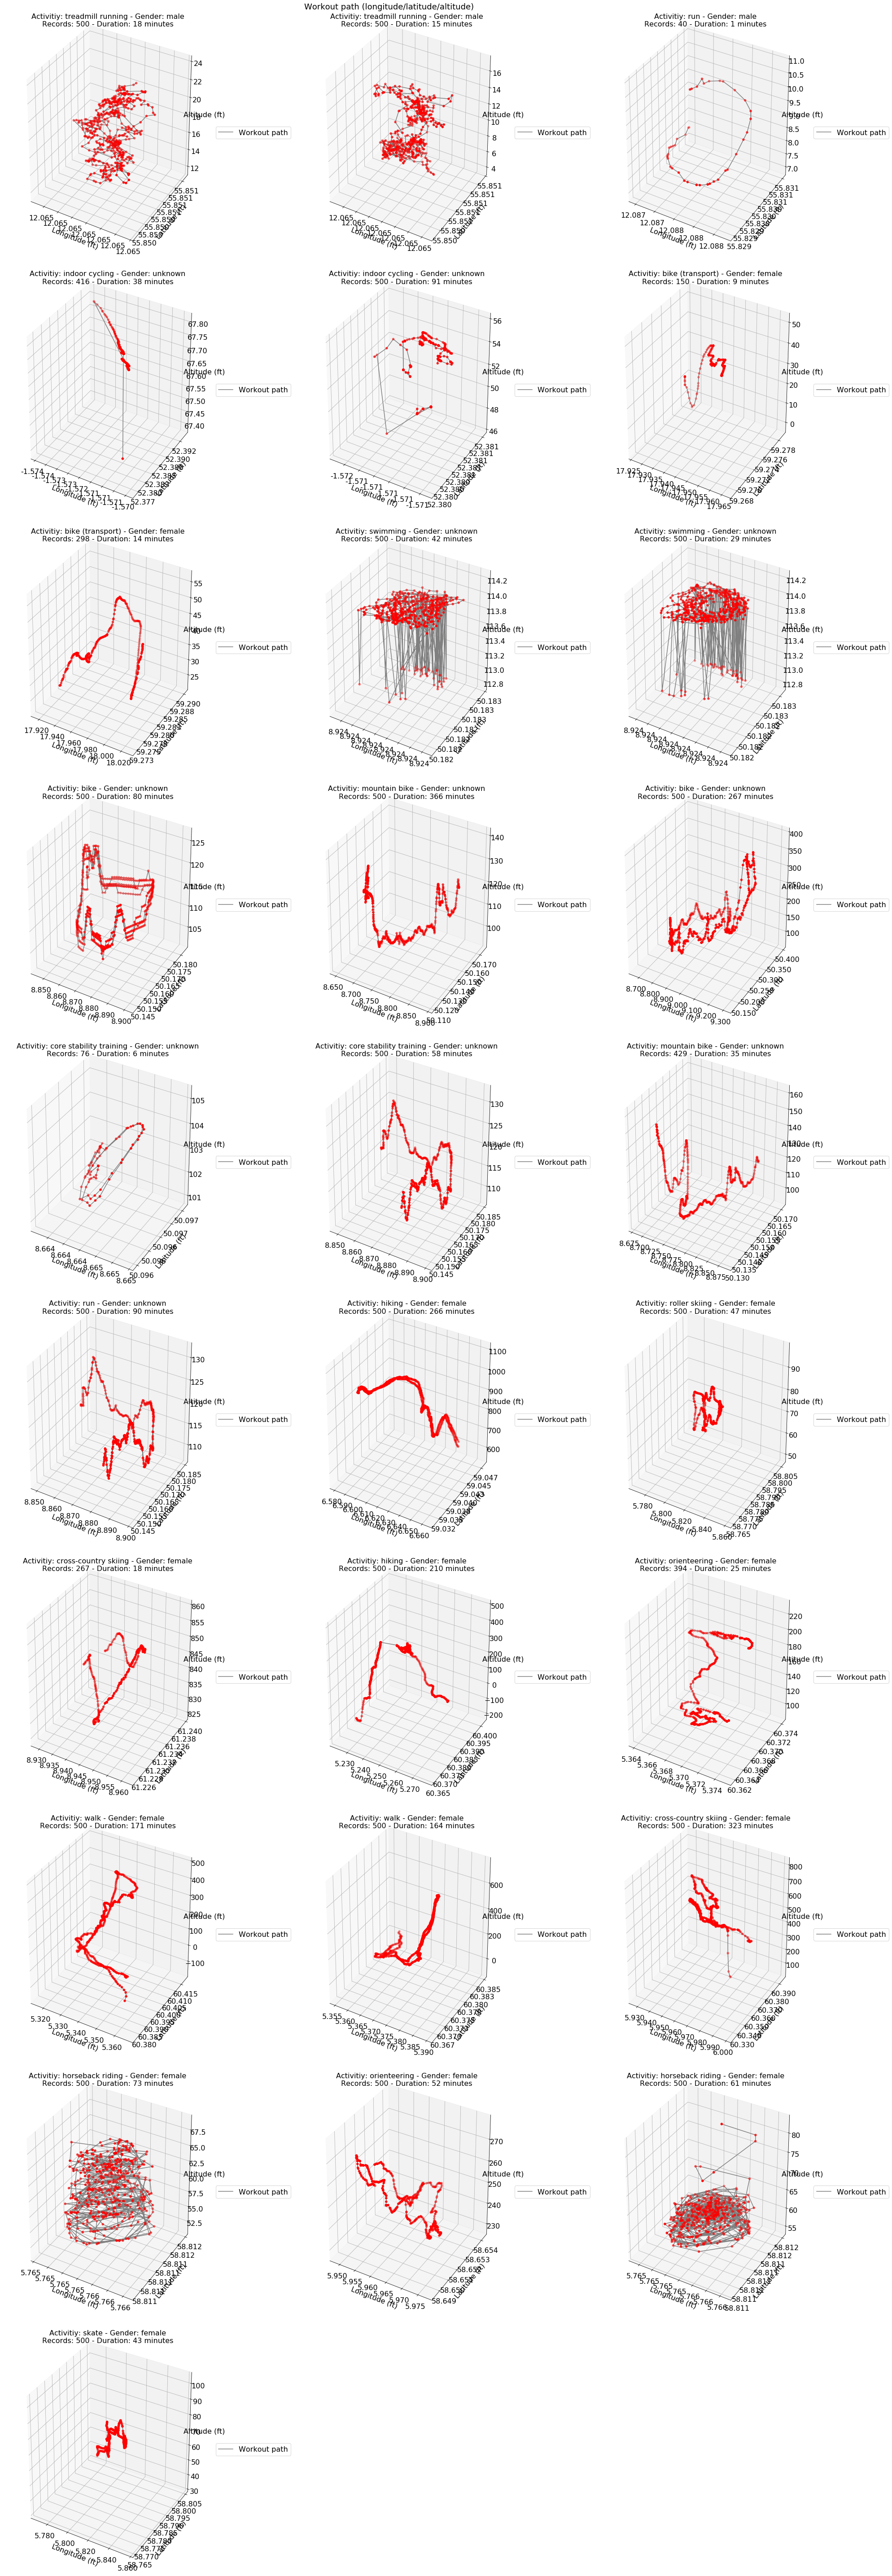

In [29]:
#pd_df_small[['userId', 'gender','sport','id', 'workout_start_time','duration', 'longitude', 'latitude', 'altitude']]
def get_fixed_mins_maxs(mins, maxs):
    deltas = (maxs - mins) / 12.
    mins = mins + deltas / 4.
    maxs = maxs - deltas / 4.

    return [mins, maxs]

workout_count = pd_df_small.shape[0]
ncols = 3
nrows = math.ceil(workout_count/ncols)
#workout_count
fig = plt.figure(figsize=(8 * (ncols + 0.5), 8*nrows))

a = fig.subplots_adjust(hspace = 0.2, wspace=0.5)
#c = plt.setp(axs, yticks=range(0,250,20))

print('Plot workout path in 3D graphs per each workout:')
for row_index, row in pd_df_small.iterrows():
    if row_index==2:
        text = ax.text2D(0.01, 1, "Workout path (longitude/latitude/altitude)", fontsize=18, transform=ax.transAxes)
    min_long = min(row['longitude']) - stats.stdev(row['longitude'])
    max_long = max(row['longitude']) + stats.stdev(row['longitude'])
    minmax_long = get_fixed_mins_maxs(min_long, max_long)
    #minmax_long
    min_lat = min(row['latitude']) - stats.stdev(row['latitude'])
    max_lat = max(row['latitude']) + stats.stdev(row['latitude'])
    minmax_lat = get_fixed_mins_maxs(min_lat, max_lat)
    #minmax_lat
    min_alt = min(row['altitude']) - stats.stdev(row['altitude'])
    max_alt = max(row['altitude']) + stats.stdev(row['altitude'])
    minmax_alt = get_fixed_mins_maxs(min_alt, max_alt)
    #minmax_alt
    ax = fig.add_subplot(nrows, ncols, row_index + 1, projection='3d')
    title = 'Activitiy: ' + row['sport'] + ' - Gender: ' + row['gender'] \
        + '\nRecords: ' + str(int(row['PerWorkoutRecordCount'])) + ' - Duration: ' + str(int(row['duration'])) + ' minutes'
    c = ax.set_title(title, fontsize=16)
    a = ax.scatter(row['longitude'], row['latitude'], row['altitude'], c='r', marker='o')
    b = ax.plot3D(row['longitude'],row['latitude'], row['altitude'], c='gray', label='Workout path')
    x_label = ax.set_xlabel('Longitude (ft)', fontsize=16)
    y_label = ax.set_ylabel('Latitude (ft)', fontsize=16)
    z_label = ax.set_zlabel('Altitude (ft)', fontsize=16, rotation = 0)
    for t in ax.xaxis.get_major_ticks():
        a = t.label.set_fontsize(16)
    for t in ax.yaxis.get_major_ticks():
        a = t.label.set_fontsize(16)
    for t in ax.zaxis.get_major_ticks():
        a = t.label.set_fontsize(16)
    b = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.zaxis.set_rotate_label(False)
    #b = plt.setp(ax.get_xticklabels(), rotation=41)
    #b = plt.setp(ax.get_yticklabels(), rotation=-30)
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    ax.pbaspect = [4, 2, 0.5]
    xlims = ax.set_xlim(minmax_long)
    ylims = ax.set_ylim(minmax_lat)
    if minmax_alt[0] != minmax_alt[1]: zlims = ax.set_zlim(minmax_alt)
    # Do this trick to enable tight_layout for 3D plot:
    for spine in ax.spines.values():
        b = spine.set_visible(False)
plt.rcParams['legend.fontsize'] = 16
a = plt.tight_layout()
plt.show()

### E. Start applying filers
As mentioned aboved, there are a few filtering actions needed before continue to next steps.    
[1] Apply filtering to remove all rows containing heart rate below 25 and above 260 bpm<br />

In [30]:
if not ['min_heart_rate', 'max_heart_rate'] in df.columns: 
    df = df.withColumn('min_heart_rate', array_min(df.heart_rate))\
            .withColumn('max_heart_rate', array_max(df.heart_rate))
df = df.filter('min_heart_rate >= 25 AND max_heart_rate <= 260')
print('\nHeart rate statistic after removing rows with abnormal records')
df.select('min_heart_rate', 'max_heart_rate').describe().toPandas()


Heart rate statistic after removing rows with abnormal records


summary      min_heart_rate      max_heart_rate
0   count              251552              251552
1    mean   87.89303205699021  164.08201087647882
2  stddev  19.152994254329606   21.09291775702986
3     min                  26                  28
4     max                 242                 254

[2]: Apply filtering to remove rows that have less that 50 records

In [31]:
filtered_df = df.filter(df.PerWorkoutRecordCount >= 50)
print('\nNumber of records per workout statistic after removing:')
filtered_df.select('PerWorkoutRecordCount').describe().toPandas()


Number of records per workout statistic after removing:


summary PerWorkoutRecordCount
0   count                246014
1    mean    450.07117887599895
2  stddev    109.77163051553163
3     min                    50
4     max                   500

Let's look at the dataset summary again after applying filtering:

In [32]:
sum_dfs= user_activity_workout_summarize(filtered_df)
print('\nOverall data set summary on users, activities(workouts) and number of fitness records (post-filtering):')
sum_dfs[0]
print('\nSummarize on genders (post-filtering):')
sum_dfs[1]


Overall data set summary on users, activities(workouts) and number of fitness records (post-filtering):


Users count Activity types count Workouts count Total records count
0       1,096                   49        246,014         110,723,811


Summarize on genders (post-filtering):


Gender  # of users  Activities (workouts) count
0  unknown          15                         1817
1   female         110                        15361
2     male         971                       228836